In [1]:
# Imports
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

Yuval Netzer, Tao Wang, Adam Coates, Alessandro Bissacco, Bo Wu, Andrew Y. Ng Reading Digits in Natural Images with Unsupervised Feature Learning NIPS Workshop on Deep Learning and Unsupervised Feature Learning 2011. (PDF)

In [2]:
# Load datasets
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

In [3]:
# Inspect variables train and test
print(type(train)) # type
print(train.keys()) # keys
print(train["X"][0]) # key x
print(train["y"][0]) # key y

<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
[[[ 33  84  19 ...  92 190 216]
  [ 30  76  54 ...  78 188 217]
  [ 38  59 110 ... 101 191 212]]

 [[ 15  86  20 ...  94 205 221]
  [ 23  73  52 ...  82 203 222]
  [ 19  66 111 ... 105 206 217]]

 [[ 15  77  25 ... 114 220 226]
  [ 17  78  57 ... 101 218 227]
  [ 19  56 116 ... 125 220 221]]

 ...

 [[ 72  90  65 ... 200 229 200]
  [ 65  78 144 ... 201 231 199]
  [ 56  69 223 ... 203 224 191]]

 [[ 82  88  78 ... 192 229 193]
  [ 77  77 148 ... 193 229 188]
  [ 57  67 218 ... 195 224 182]]

 [[ 89  88  98 ... 190 229 197]
  [ 79  78 158 ... 191 228 189]
  [ 59  66 220 ... 193 223 186]]]
[1]


In [4]:
# Assign values to variables
x_train = np.array(train["X"])
y_train = train["y"]
x_test = np.array(test["X"])
y_test = test["y"]

In [5]:
# shape of the data
print(x_train.shape)
print(x_test.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)


In [6]:
# fix axes of x_train and x_test
x_train = np.moveaxis(x_train, -1, 0)
x_test = np.moveaxis(x_test, -1, 0)

In [7]:
# convert images and labels and normalize images
x_train = x_train.astype("float64") / 255.0
x_test = x_test.astype("float64") / 255.0
y_train = y_train.astype("int64")
y_test = y_test.astype("int64")

In [8]:
# random sample of images and labels from train dataset
# select x random numbers from 0 to len(dataset[0])-1
def get_random_numbers(number_of_images, dataset, mode):
    random_numbers = []
    if mode == "color":
        max_range = len(dataset[0]) - 1
        while len(random_numbers) < number_of_images:
            random_number = randint(0, max_range)
            if random_number not in random_numbers:
                random_numbers.append(random_number)
    if mode == "gray":
        max_range = len(dataset) - 1
        while len(random_numbers) < number_of_images:
            random_number = randint(0, max_range)
            if random_number not in random_numbers:
                random_numbers.append(random_number)
    return random_numbers

In [9]:
# function to show images and labels
def display_images(numbers, images, labels, mode):
    if mode == "color":
        for number in numbers:
            plt.imshow(images[number])
            plt.show()
            print("Label: " + str(labels[number]))
    if mode == "gray":
        for number in numbers:
            plt.imshow(images[number], cmap="gray")
            plt.show()
            print("Label: " + str(labels[number]))

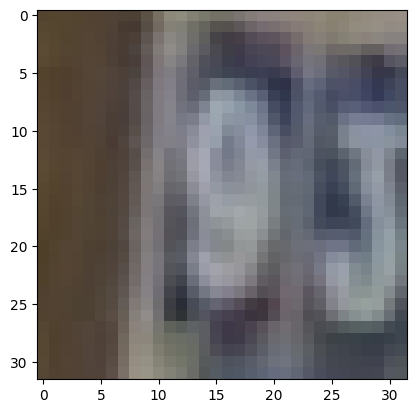

Label: [9]


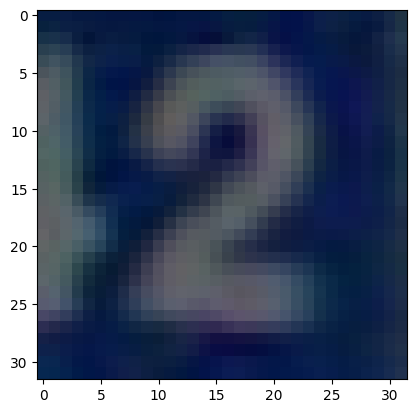

Label: [2]


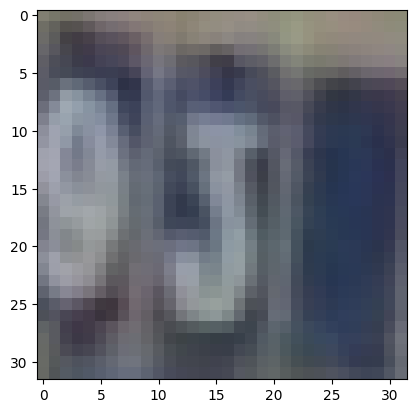

Label: [3]


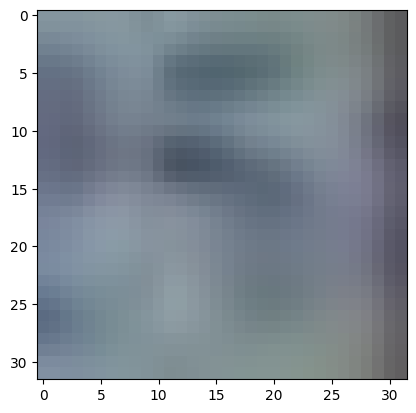

Label: [5]


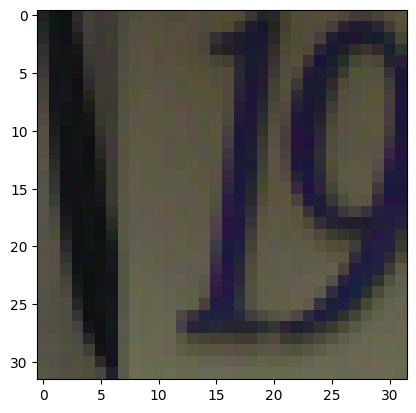

Label: [1]


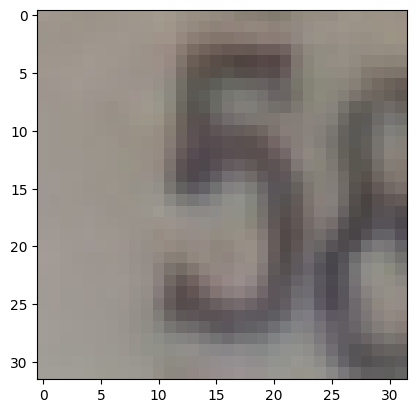

Label: [5]


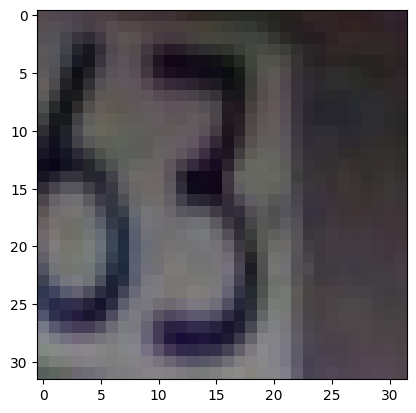

Label: [3]


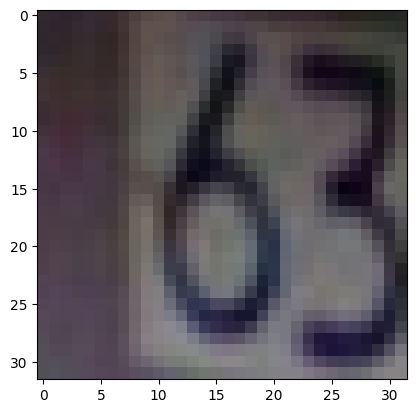

Label: [6]


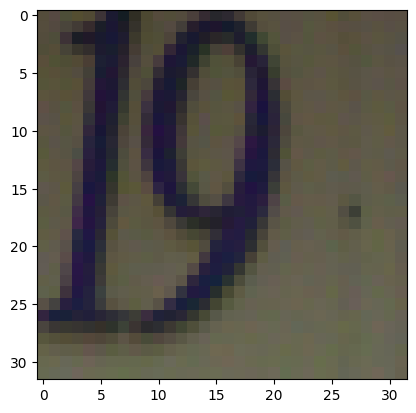

Label: [9]


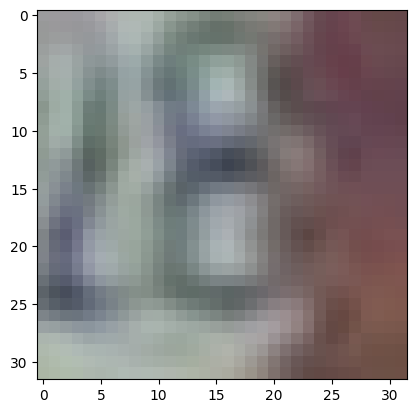

Label: [8]


In [10]:
# The random numbers will be used as index of x_train and y_train to obtain the random sample
random_numbers = get_random_numbers(10, x_train, "color")
display_images(random_numbers, x_train, y_train, "color")

In [11]:
# convert the training and test images to grayscale
def convert_grayscale(dataset):
    gray_images = []
    for i in range(len(dataset)):
        image = dataset[i]
        r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
        y = 0.299*r + 0.587*g + 0.114*b
        gray_images.append(y)
    return gray_images

In [12]:
gray_train = convert_grayscale(x_train)
gray_test = convert_grayscale(x_test)

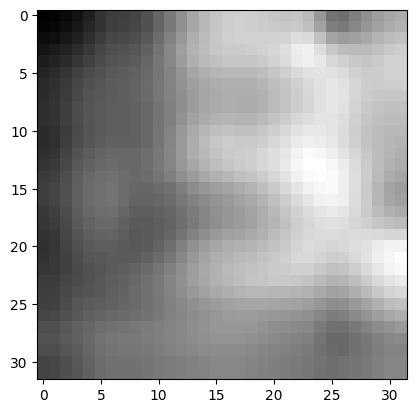

Label: [9]


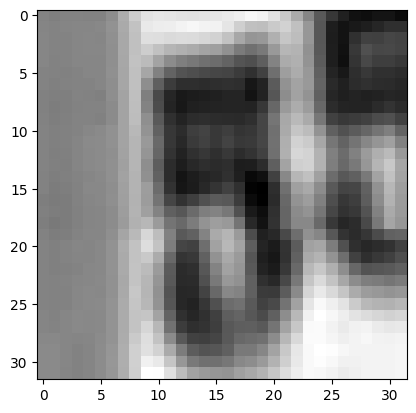

Label: [5]


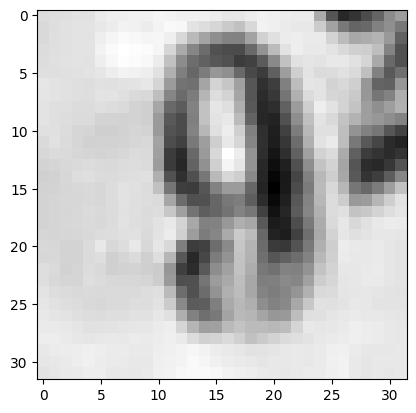

Label: [9]


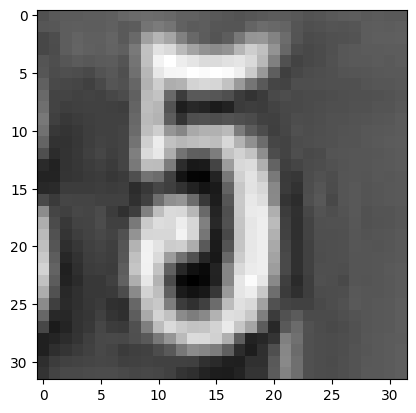

Label: [5]


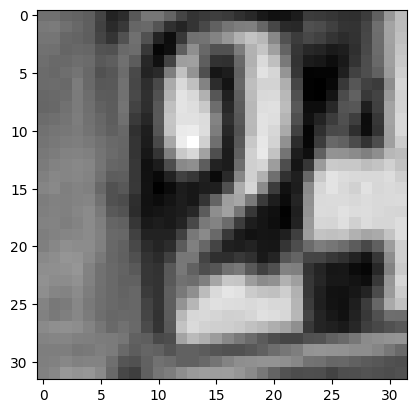

Label: [2]


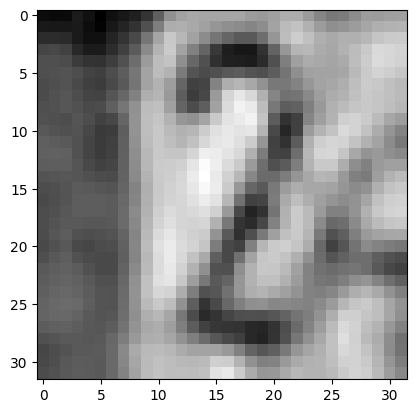

Label: [2]


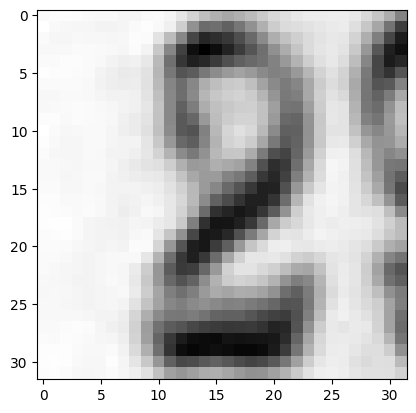

Label: [2]


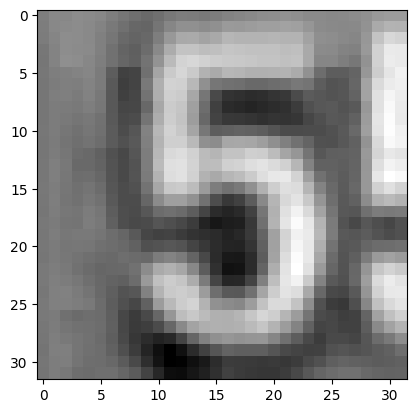

Label: [5]


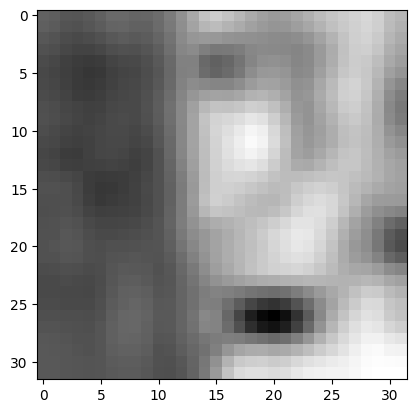

Label: [2]


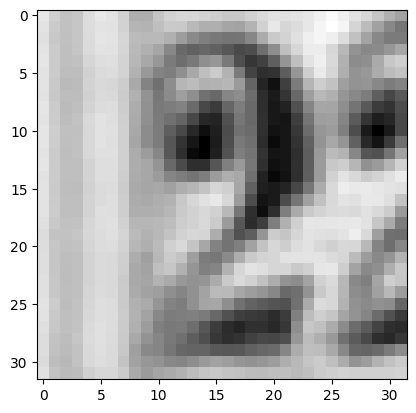

Label: [2]


In [13]:
random_numbers_gray = get_random_numbers(10, gray_train, "gray")
display_images(random_numbers_gray, gray_train, y_train, "gray")

In [14]:
# before starting with the classifiers, convert the labels "10" to "0"
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

In [15]:
def get_model_MLP():
  model_MLP = Sequential([
    Dense(32, activation="relu", input_shape=x_train[0].shape, name="dense_1"),
    Flatten(name="flatten_1"),
    Dense(700, activation="relu", name="dense_2"),
    Flatten(name="flatten_2"),
    Dense(10, activation="softmax", name="final_layer")
  ])
  return model_MLP

In [16]:
model_MLP = get_model_MLP()
model_MLP.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 700)            │    22,938,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_layer (Dense)             │ (None, 10)             │         7,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,945,438 (87.53 MB)

 Trainable params: 22,945,438 (87.53 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# function to save the whole model when validation accuracy improves
def get_checkpoint_best():
  checkpoint_path_MLP = "checkpoints_best_MLP/checkpoint.keras"
  checkpoint_best_MLP = ModelCheckpoint(filepath=checkpoint_path_MLP, save_freq="epoch", save_weights_only=False, monitor="val_accuracy", save_best_only=True, verbose=1)
  checkpoint_path_CNN = "checkpoints_best_CNN/checkpoint.keras"
  checkpoint_best_CNN = ModelCheckpoint(filepath=checkpoint_path_CNN, save_freq="epoch", save_weights_only=False, monitor="val_accuracy", save_best_only=True, verbose=1)
  return checkpoint_best_MLP, checkpoint_best_CNN

In [18]:
# Early stopping callback
# If validation accuracy does not improve in 4 epochs, process stops
def get_early_stopping():
    early_stopping = EarlyStopping(monitor="val_accuracy", patience=4, verbose=1)
    return early_stopping

In [19]:
# Some callbacks for the fit process
class TrainingCallback(Callback):
    def on_train_begin(self, logs=None):
        print("Starting training...")
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}")
    def on_train_end(self, logs=None):
        print("Finished training!")

In [20]:
class TestingCallback(Callback):
    def on_test_begin(self, logs=None):
        print("Starting testing...")
    def on_test_end(self, logs=None):
        print("Finished testing!")

In [21]:
class PredictionCallback(Callback):
    def on_predict_begin(self, logs=None):
        print("Starting prediction...")
    def on_predict_end(self, logs=None):
        print("Finished prediction!")

In [25]:
checkpoint_best_MLP, checkpoint_best_CNN = get_checkpoint_best()
early_stopping = get_early_stopping()

In [26]:
# Compile model
model_MLP.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history_MLP = model_MLP.fit(x_train, y_train, epochs=30, batch_size=120, validation_split=0.1, verbose=1,
          callbacks=[TrainingCallback(), checkpoint_best_MLP, early_stopping])

Starting training...
Starting epoch 0
Epoch 1/30
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2195 - loss: 2.6032Finished epoch 0

Epoch 1: val_accuracy improved from -inf to 0.51147, saving model to checkpoints_best_MLP/checkpoint.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.2196 - loss: 2.6022 - val_accuracy: 0.5115 - val_loss: 1.5037
Starting epoch 1
Epoch 2/30
546/550 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5636 - loss: 1.3573Finished epoch 1

Epoch 2: val_accuracy improved from 0.51147 to 0.65848, saving model to checkpoints_best_MLP/checkpoint.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5640 - loss: 1.3564 - val_accuracy: 0.6585 - val_loss: 1.0948
Starting epoch 2
Epoch 3/30
547/550 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6794 - loss: 1.0365Finished epoch 2

Epoch 3: val_accuracy improved from 0.65848 to 0.71608, saving model to checkpoints_best_MLP/checkpoint.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accura

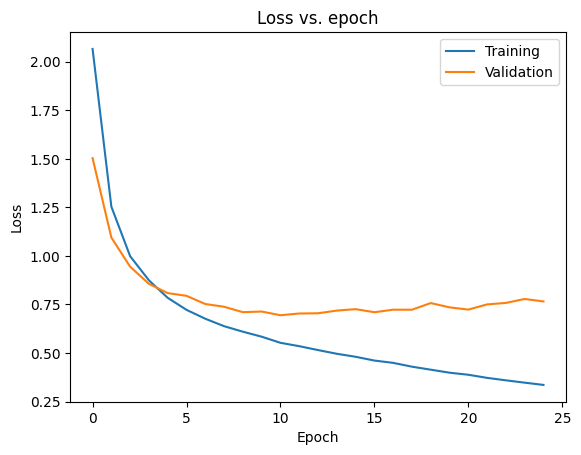

In [27]:
# Learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets
# %matplotlib inline
# Loss vs. epoch
plt.plot(history_MLP.history['loss'])
plt.plot(history_MLP.history['val_loss'])
plt.title('Loss vs. epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

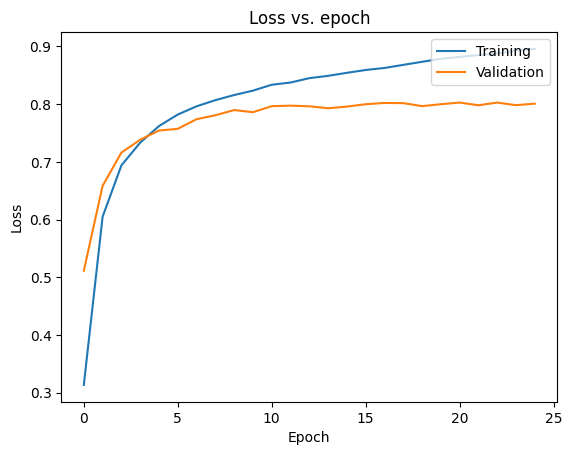

In [28]:
# Accuracy vs. epoch
plt.plot(history_MLP.history['accuracy'])
plt.plot(history_MLP.history['val_accuracy'])
plt.title('Loss vs. epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [29]:
# Evaluate model with test dataset
model_MLP.evaluate(x_test, y_test, verbose=1)

814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7665 - loss: 1.0843


[1.048394799232483, 0.7670943737030029]

In [30]:
def get_model_CNN():
  model_CNN = Sequential([
    Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation="relu", name="Conv2D_1"),
    BatchNormalization(name="BatchNormalization"),
    Conv2D(60, (3, 3), activation="relu", name="Conv2D_2"),
    MaxPooling2D((2, 2), name="MaxPooling2D"),
    Dropout(0.3, name="Dropout"),
    Flatten(name="Flatten"),
    Dense(10, activation="softmax", name="Dense_final_layer")
  ])
  return model_CNN

In [31]:
model_CNN = get_model_CNN()
model_CNN.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_1 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNormalization              │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_2 (Conv2D)               │ (None, 28, 28, 60)     │        17,340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D (MaxPooling2D)     │ (None, 14, 14, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 14, 14, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 11760)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_final_layer (Dense)       │ (None, 10)             │       117,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,974 (531.15 KB)

 Trainable params: 135,910 (530.90 KB)

 Non-trainable params: 64 (256.00 B)

In [32]:
# compile model
model_CNN.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history_CNN = model_CNN.fit(x_train, y_train, epochs=30, batch_size=120, validation_split=0.1, verbose=1,
          callbacks=[TrainingCallback(), checkpoint_best_CNN, early_stopping])

Starting training...
Starting epoch 0
Epoch 1/30
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6123 - loss: 1.2328Finished epoch 0

Epoch 1: val_accuracy improved from -inf to 0.81299, saving model to checkpoints_best_CNN/checkpoint.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.6126 - loss: 1.2321 - val_accuracy: 0.8130 - val_loss: 0.8932
Starting epoch 1
Epoch 2/30
547/550 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8530 - loss: 0.5080Finished epoch 1

Epoch 2: val_accuracy improved from 0.81299 to 0.83361, saving model to checkpoints_best_CNN/checkpoint.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8530 - loss: 0.5080 - val_accuracy: 0.8336 - val_loss: 0.5636
Starting epoch 2
Epoch 3/30
547/550 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8714 - loss: 0.4425Finished epoch 2

Epoch 3: val_accuracy improved from 0.83361 to 0.86036, saving model to checkpoints_best_CNN/checkpoint.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.

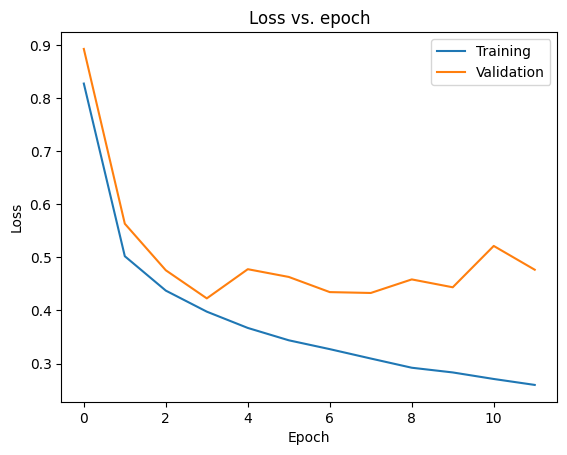

In [33]:
# Learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets
# %matplotlib inline
# Loss vs. epoch
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])
plt.title('Loss vs. epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

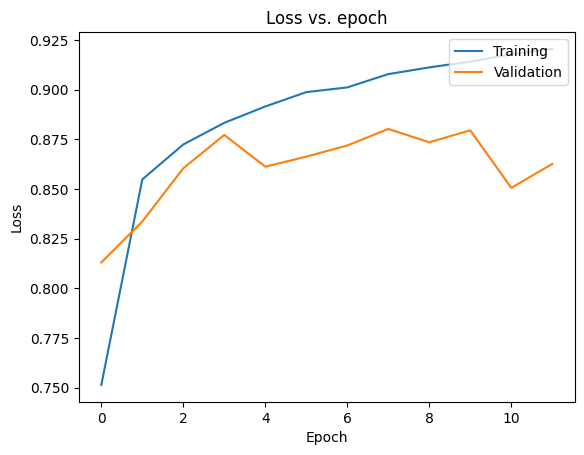

In [34]:
# Accuracy vs. epoch
plt.plot(history_CNN.history['accuracy'])
plt.plot(history_CNN.history['val_accuracy'])
plt.title('Loss vs. epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [35]:
# Evaluate model with test dataset
model_CNN.evaluate(x_test, y_test, verbose=1)

814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8376 - loss: 0.5983


[0.5811630487442017, 0.841925323009491]

In [38]:
# Load saved models
model_MLP2 = load_model("checkpoints_best_MLP/checkpoint.keras")
model_CNN2 = load_model("checkpoints_best_CNN/checkpoint.keras")

In [39]:
# Function to select x random numbers from test dataset
import random
def x_random_numbers(dataset, numbers_quantity):
  random_numbers = []
  for i in range(numbers_quantity):
    number = random.randint(0, (len(dataset) - 1))
    random_numbers.append(number)
  return random_numbers

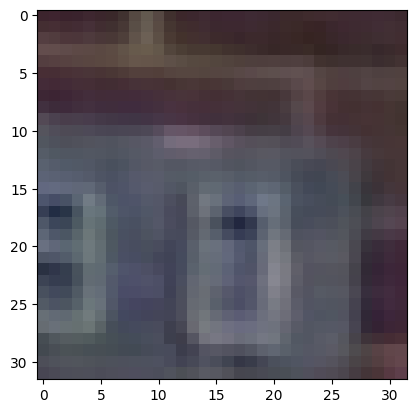

Label: [0]


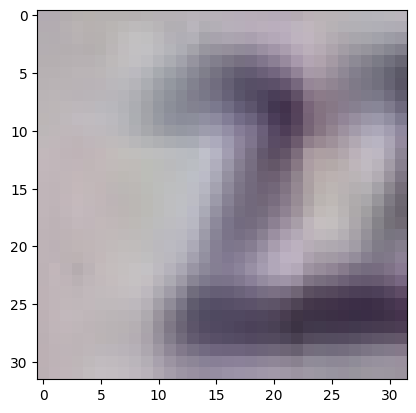

Label: [2]


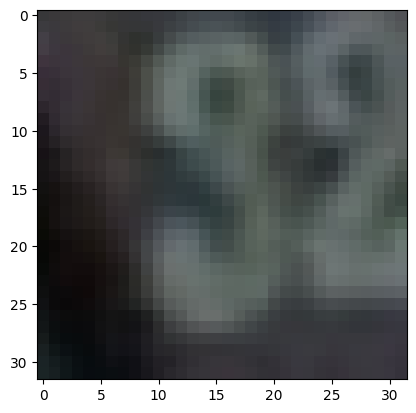

Label: [3]


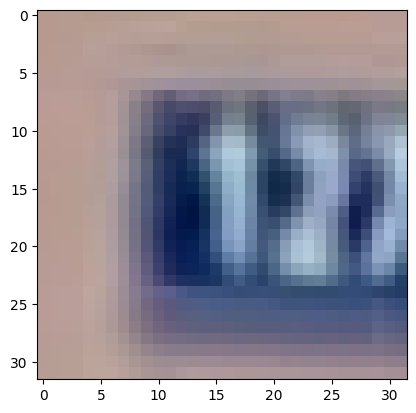

Label: [1]


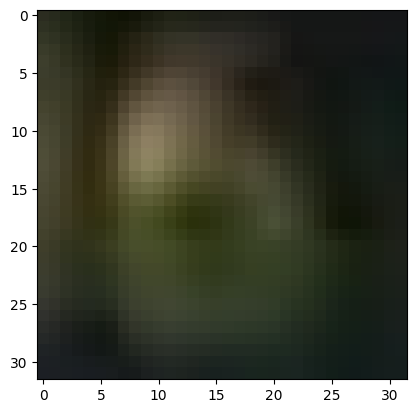

Label: [6]


In [40]:
# Display images and labels
random_numbers = x_random_numbers(x_test, 5)
display_images(random_numbers, x_test, y_test, "color")

In [41]:
# Show images with label and model’s predictive distribution as a bar chart and the final model prediction
def show_all(numbers, images, labels, model_MLP, model_CNN):
#   %matplotlib inline
  # get indexes to show images and labels in a list
  indexes = []
  for number in numbers:
    indexes.append(number)
    indexes.append(number)
  # predictions
  MLP_pred_percentages = model_MLP.predict(images, verbose=0)
  MLP_pred_classes = np.argmax(MLP_pred_percentages, axis=1)
  CNN_pred_percentages = model_CNN.predict(images, verbose=0)
  CNN_pred_classes = np.argmax(CNN_pred_percentages, axis=1)
  # Displays
  for index in indexes:
    # Display image
    plt.imshow(images[index])
    plt.show()
    # Display correct label
    print("Label: " + str(labels[index]))
    # Display MLP bar chart
    labels_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    values_MLP = list(MLP_pred_percentages[index])
    figure_MLP = plt.figure(figsize=(10, 5))
    plt.bar(labels_list, values_MLP, width=0.35)
    plt.xlabel("Labels")
    plt.ylabel("Probability")
    plt.title("MLP model bar chart")
    plt.show()
    # Display CNN bar chart
    values_CNN = list(CNN_pred_percentages[index])
    figure_CNN = plt.figure(figsize=(10, 5))
    plt.bar(labels_list, values_CNN, width=0.35)
    plt.xlabel("Labels")
    plt.ylabel("Probability")
    plt.title("CNN model bar chart")
    plt.show()
    # Display predictions
    print("Prediction MLP model: " + str(MLP_pred_classes[index]))
    print("Prediction CNN model: " + str(CNN_pred_classes[index]))

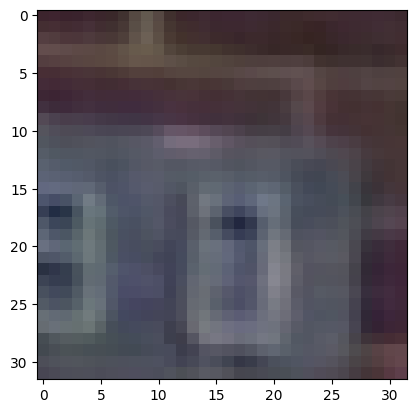

Label: [0]


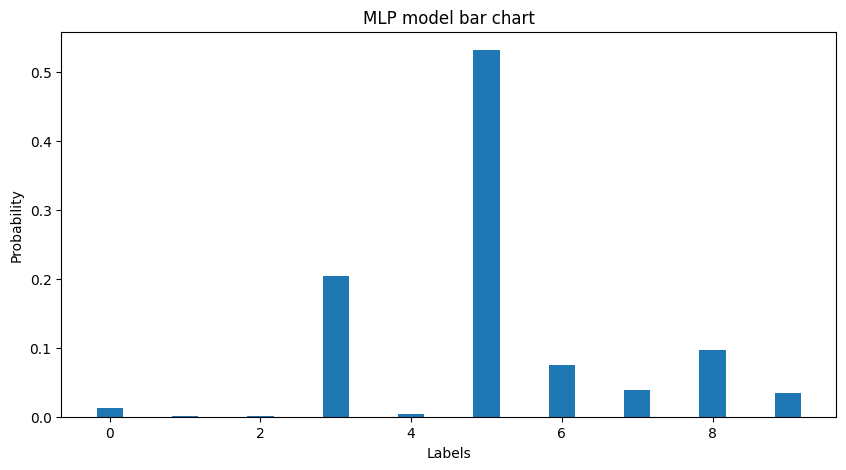

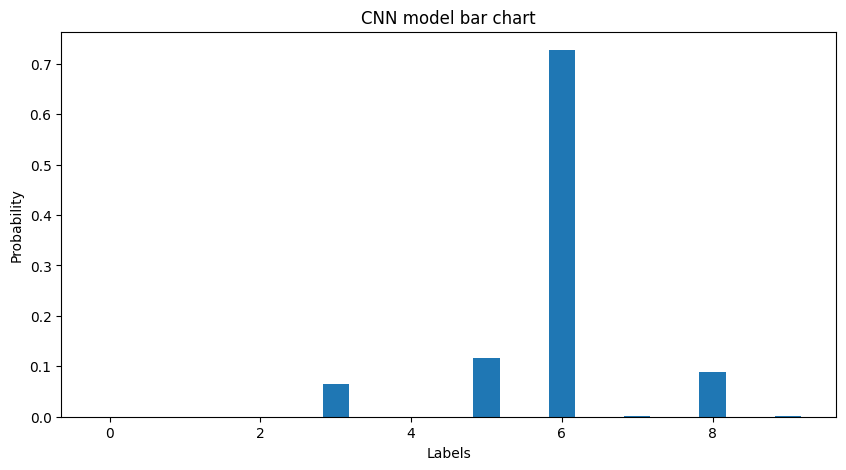

Prediction MLP model: 5
Prediction CNN model: 6


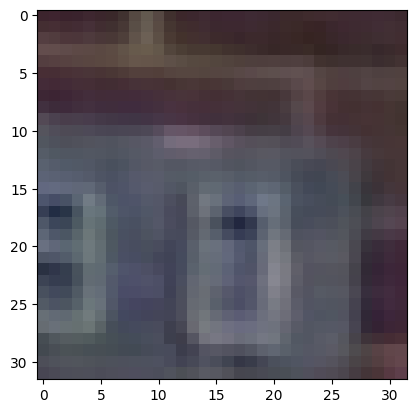

Label: [0]


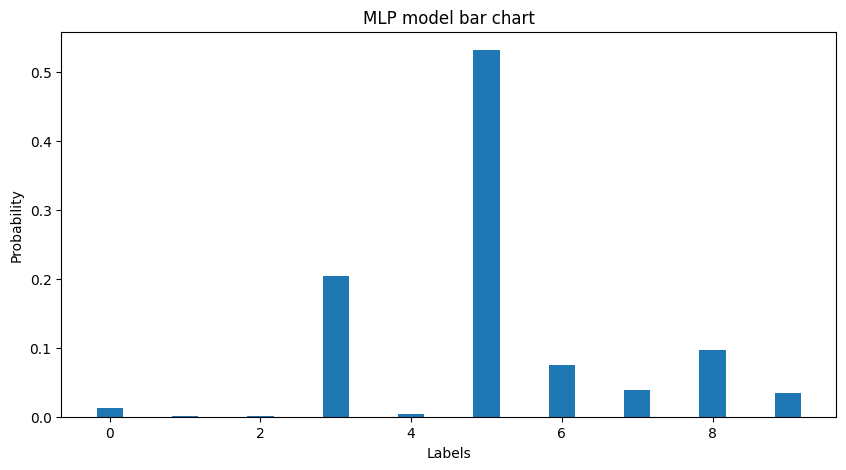

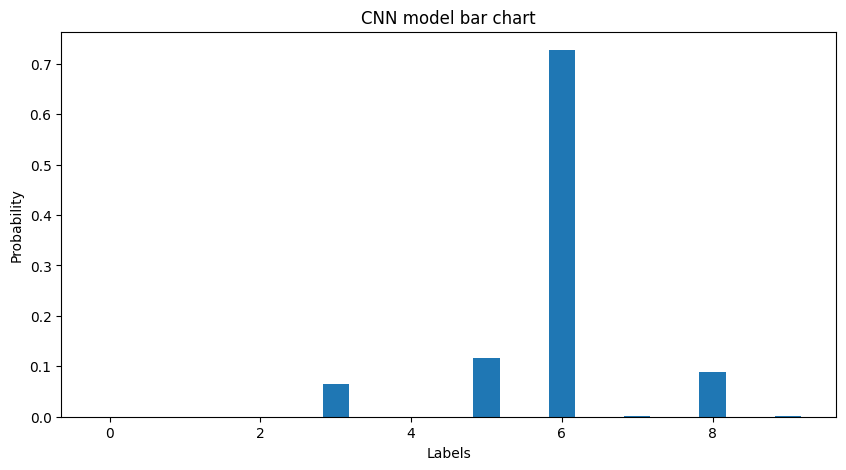

Prediction MLP model: 5
Prediction CNN model: 6


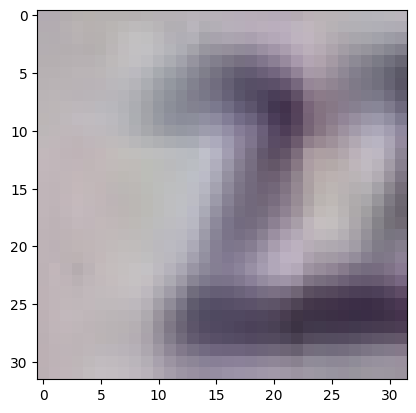

Label: [2]


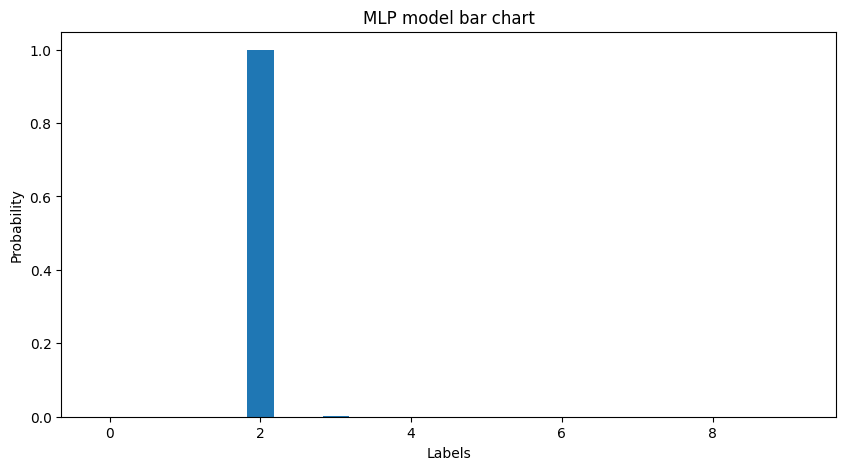

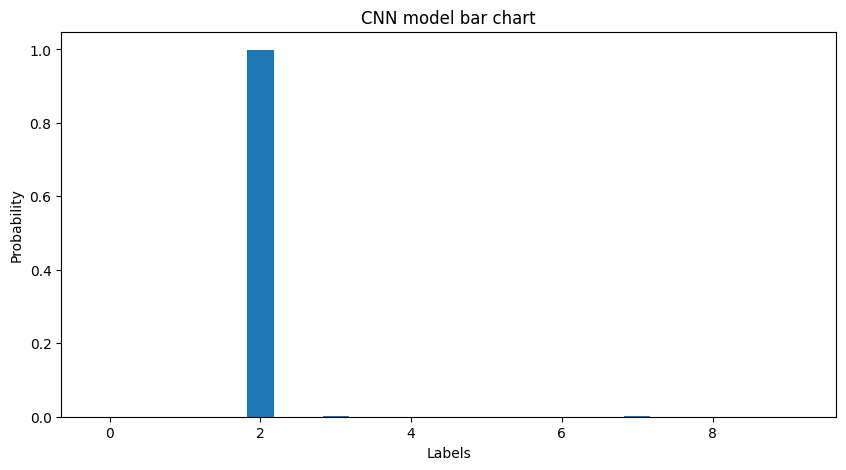

Prediction MLP model: 2
Prediction CNN model: 2


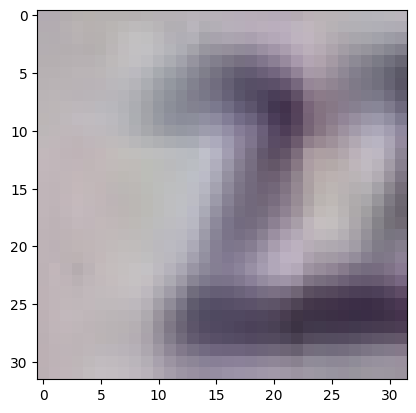

Label: [2]


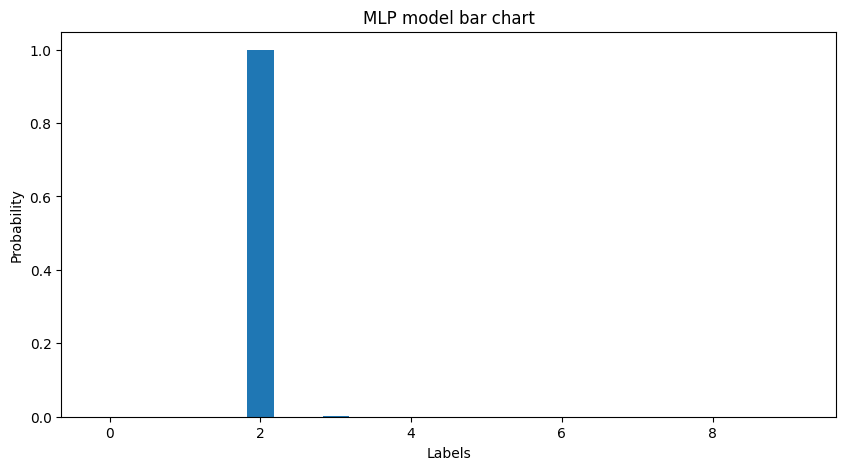

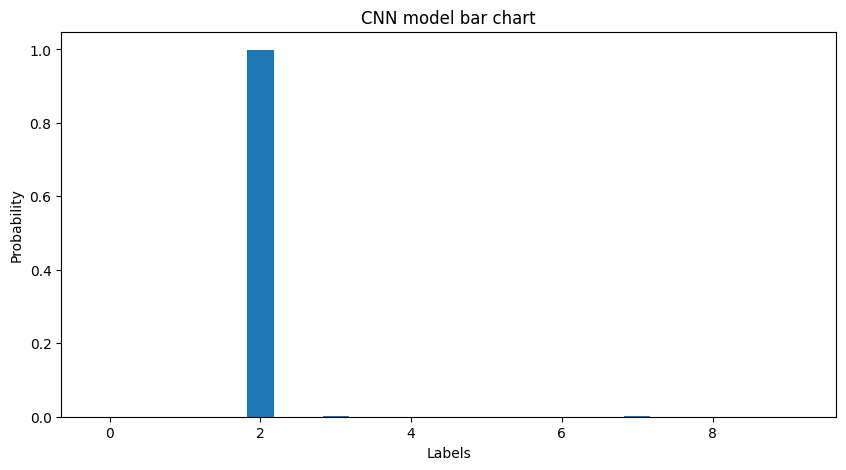

Prediction MLP model: 2
Prediction CNN model: 2


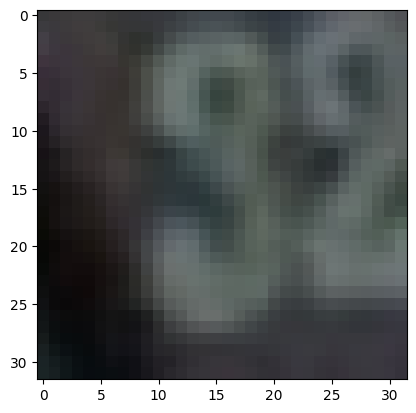

Label: [3]


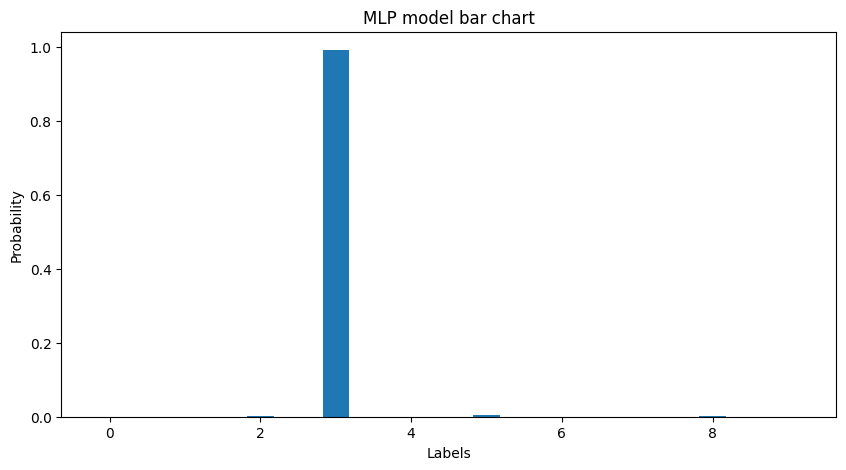

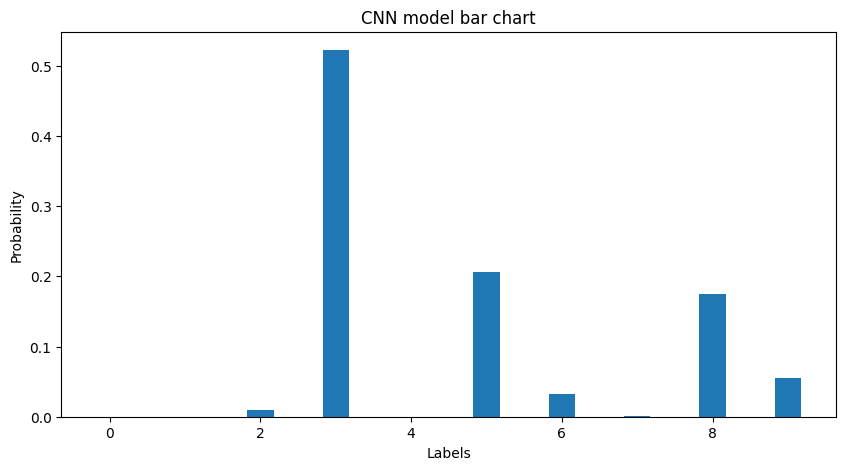

Prediction MLP model: 3
Prediction CNN model: 3


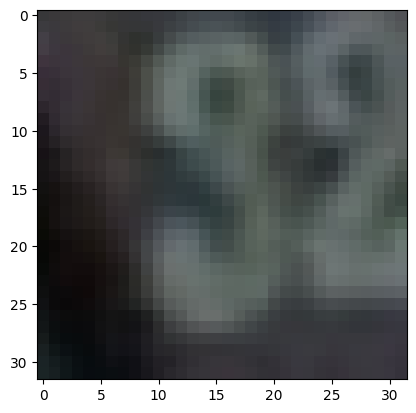

Label: [3]


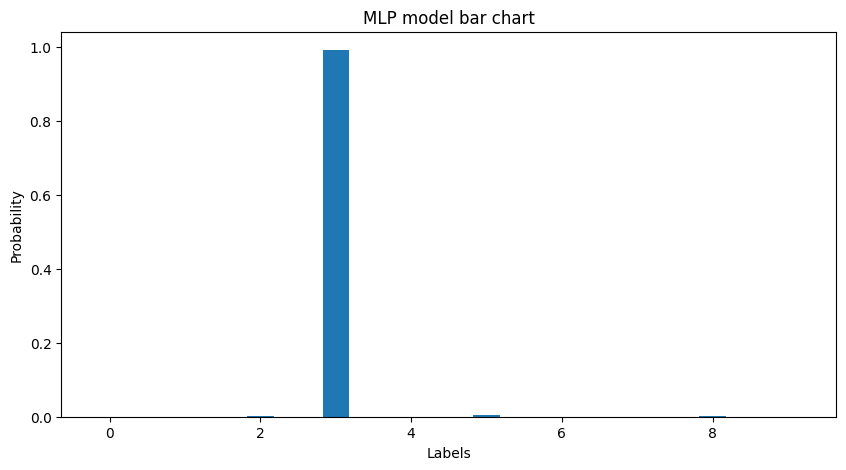

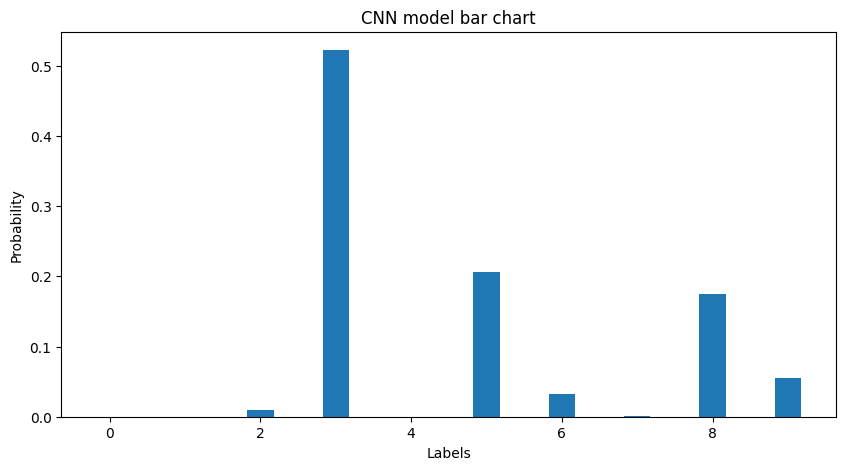

Prediction MLP model: 3
Prediction CNN model: 3


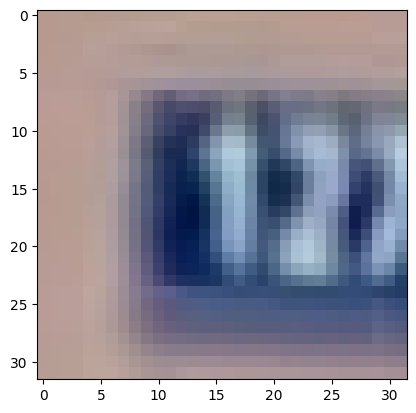

Label: [1]


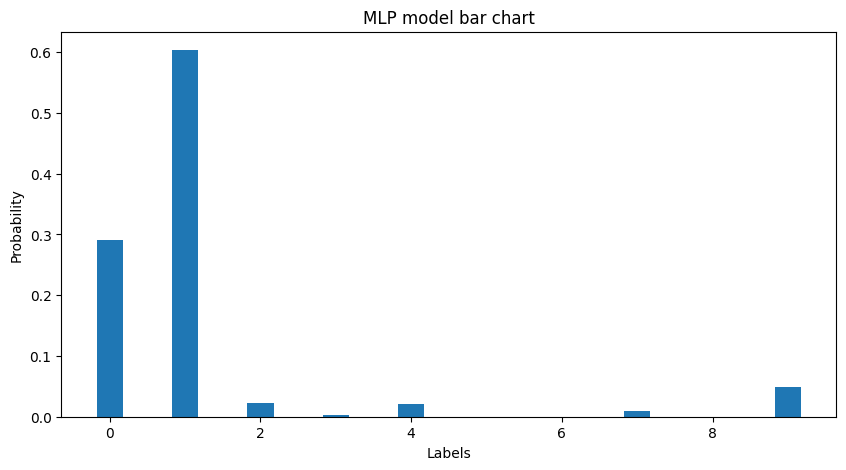

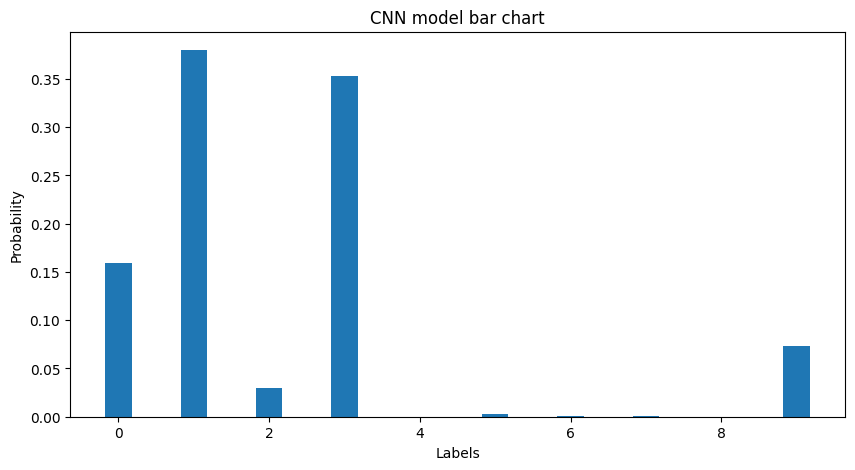

Prediction MLP model: 1
Prediction CNN model: 1


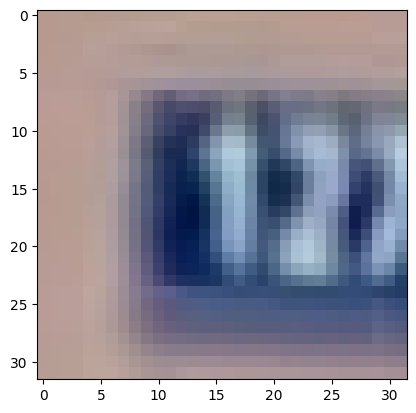

Label: [1]


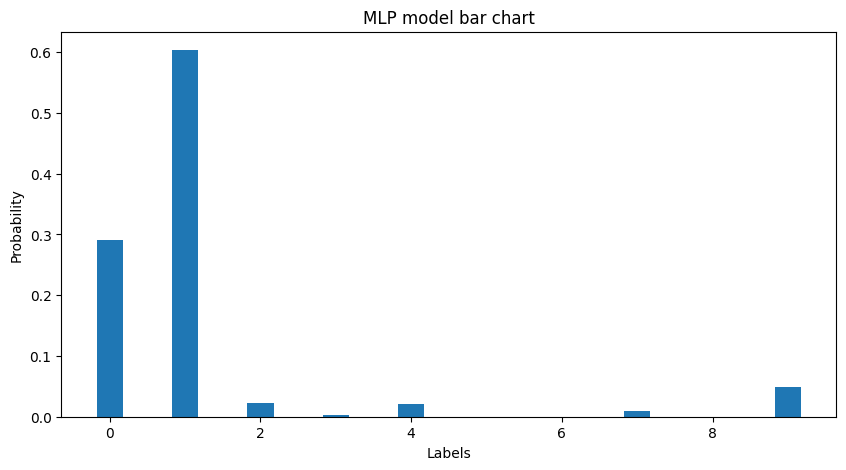

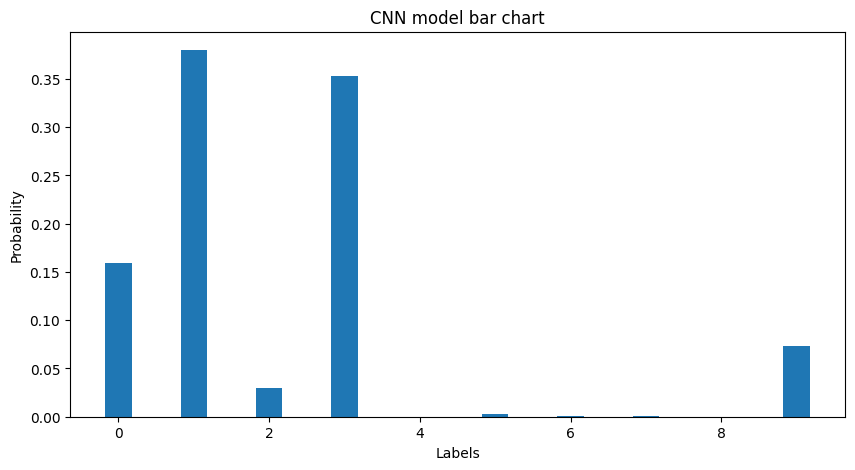

Prediction MLP model: 1
Prediction CNN model: 1


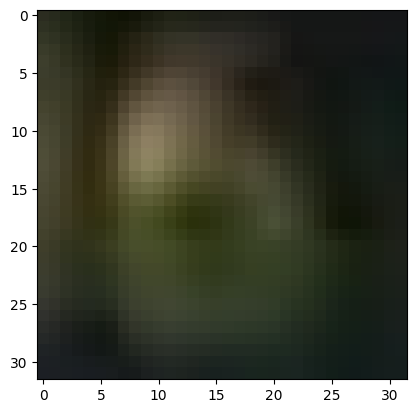

Label: [6]


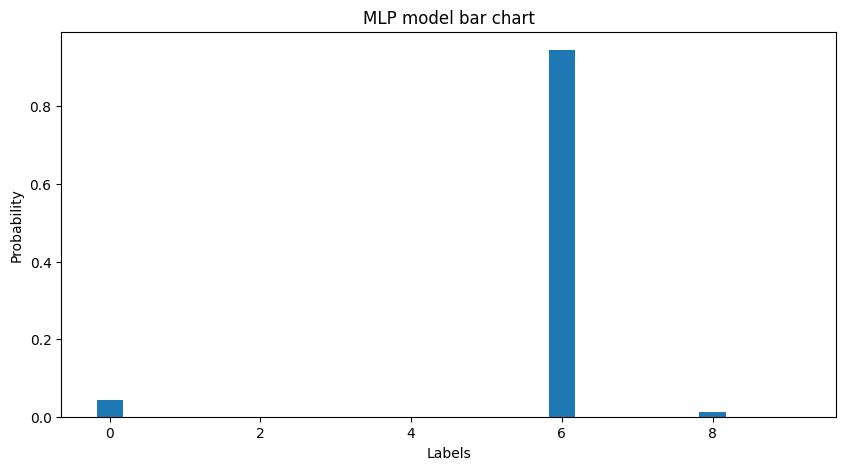

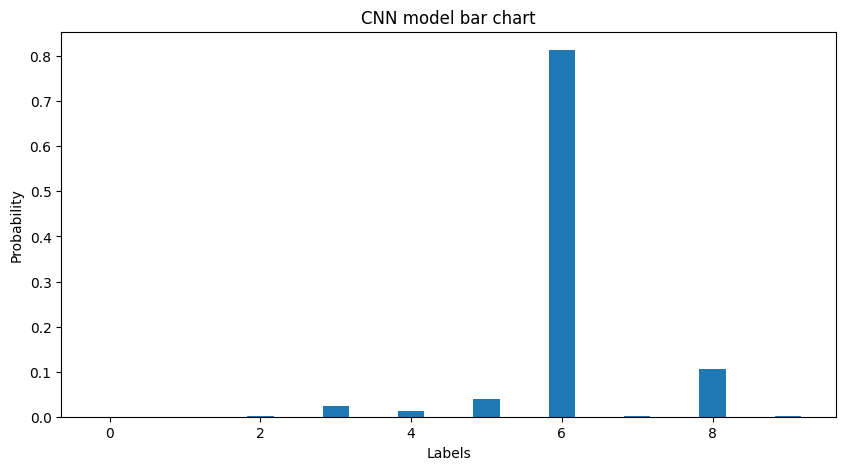

Prediction MLP model: 6
Prediction CNN model: 6


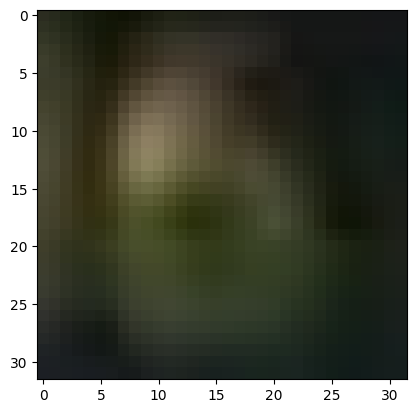

Label: [6]


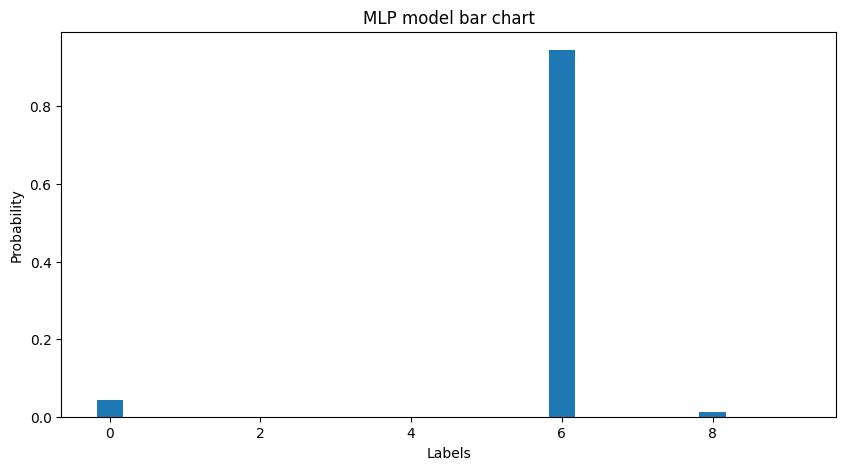

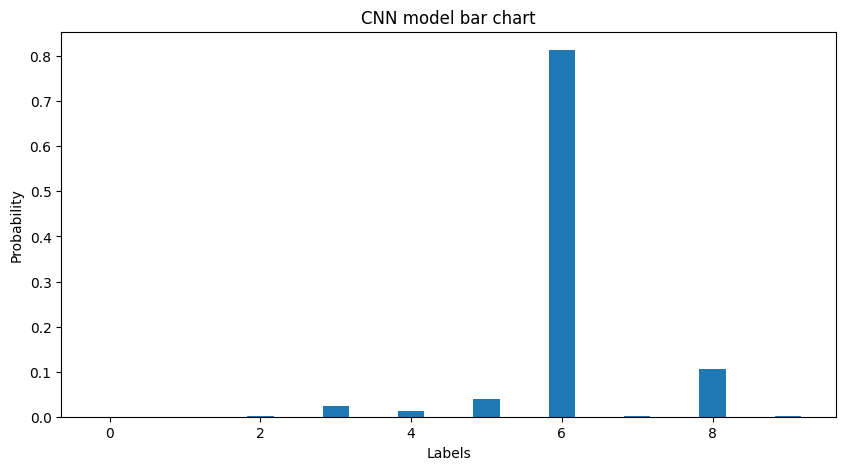

Prediction MLP model: 6
Prediction CNN model: 6


In [42]:
show_all(random_numbers, x_test, y_test, model_MLP2, model_CNN2)